In [1]:
!pip show nd2

Name: nd2
Version: 0.10.1
Summary: Yet another nd2 (Nikon NIS Elements) file reader
Home-page: https://github.com/tlambert03/nd2
Author: 
Author-email: Talley Lambert <talley.lambert@gmail.com>
License: BSD 3-Clause License
Location: /Users/meliscelik/miniconda3/envs/trial-env/lib/python3.9/site-packages
Requires: numpy, ome-types, resource-backed-dask-array, typing-extensions
Required-by: 


In [2]:
pip install plotly

Note: you may need to restart the kernel to use updated packages.


In [16]:
pip install nd2reader

Note: you may need to restart the kernel to use updated packages.


In [17]:
import nd2reader
print(nd2reader.__version__)

3.3.0


In [18]:
import nd2reader
import nd2
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table
import seaborn as sns
from skimage import io, measure, morphology, filters
from skimage.color import rgb2gray
from skimage.measure import label, regionprops_table
from skimage.util import img_as_ubyte
from skimage.filters import threshold_otsu, gaussian
from skimage.segmentation import clear_border
from skimage.morphology import area_opening
from skimage.measure import label, regionprops_table
from scipy.ndimage import gaussian_filter 
from scipy.ndimage import label  
import stackview
from nd2reader import ND2Reader
import plotly.graph_objects as go

In [19]:
# Load ND2 file and extract channels
file_path = '/Users/meliscelik/Desktop/20240605_d63_wt_ki67_488_sox2_555_map2_638_20x001-maxip_xy4 copy.nd2'

def load_nd2_file(file_path):
    with nd2.ND2File(file_path) as figure:
        image = figure.asarray()  # Read image data
        print(f"File path: {figure.path}")
        print(f"File shape: {figure.shape}")
        return image

# Normalize channel images
def normalize_channel(image):
    normalized_image = (image * (1000 / image.max())).astype(np.uint16)
    return normalized_image


In [20]:
# Plot and visualize image at different stages
def visualize_image(image, title, cmap='gray'):
    plt.figure(figsize=(4, 4), dpi=150)
    plt.imshow(image, cmap=cmap)
    plt.colorbar()
    plt.title(title)
    plt.axis('off')
    plt.show()


In [21]:
from skimage.measure import label, regionprops_table

# Process each channel for segmentation
def process_channel(channel, channel_name):
    # Step 1: Visualize Original Channel
    visualize_image(channel, f"Original Image - {channel_name}")

    # Step 2: Background subtraction
    img_bg = gaussian(channel, sigma=50, preserve_range=True)
    img_no_bg = channel - img_bg
    visualize_image(img_bg, f"Background - {channel_name}")
    visualize_image(img_no_bg, f"Background Corrected - {channel_name}")

    # Step 3: Thresholding (Otsu)
    th_val = threshold_otsu(img_no_bg)
    bw_otsu = img_no_bg > th_val
    visualize_image(bw_otsu, f"Thresholding (Otsu) - {channel_name}")

    # Step 4: Remove border touching segments and small objects
    mask = clear_border(bw_otsu)
    mask = area_opening(mask, area_threshold=200)
    visualize_image(mask, f"After Border Removal & Area Opening - {channel_name}")

    # Step 5: Label connected components
    lbl = label(mask)
    visualize_image(lbl, f"Connected Component Analysis - {channel_name}", cmap='nipy_spectral')

    # Step 6: Region properties
    properties = ['label', 'area', 'eccentricity', 'intensity_mean']
    table = regionprops_table(label_image=lbl, intensity_image=channel, properties=properties)
    df = pd.DataFrame(table)
    
    return df, lbl  # Ensure only the DataFrame and labeled image are returned


File path: /Users/meliscelik/Desktop/20240605_d63_wt_ki67_488_sox2_555_map2_638_20x001-maxip_xy4 copy.nd2
File shape: (4, 2048, 2048)


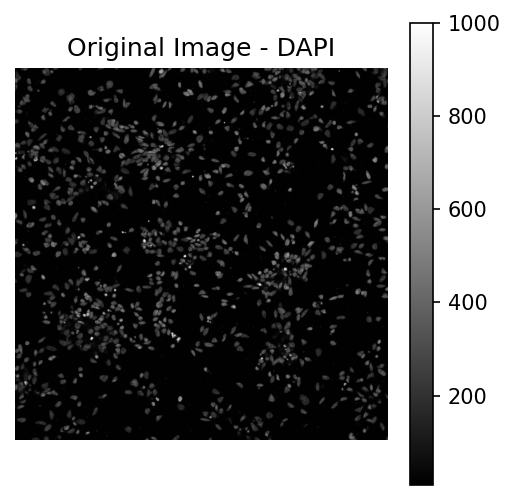

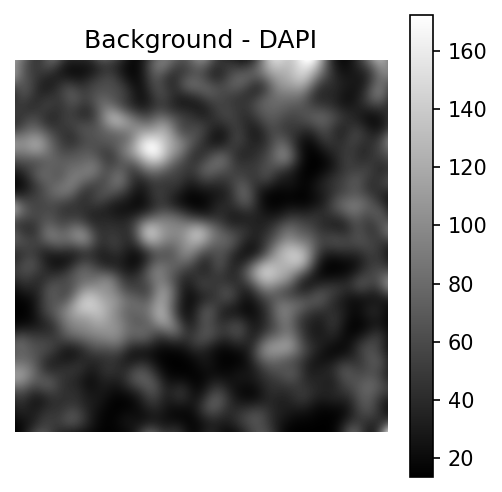

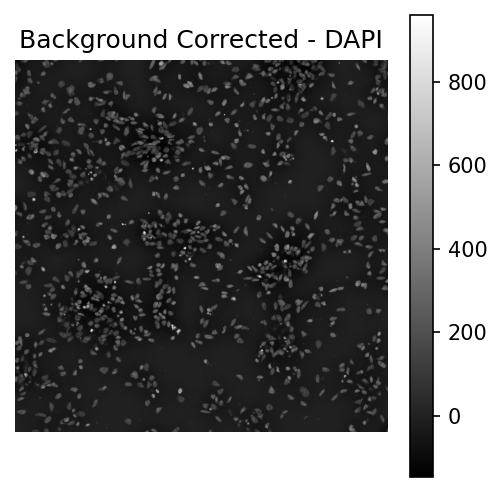

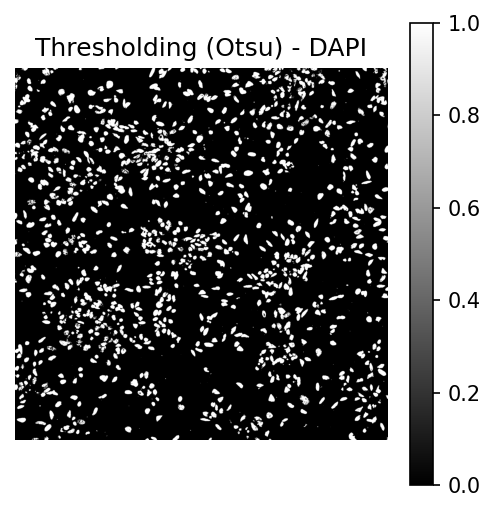

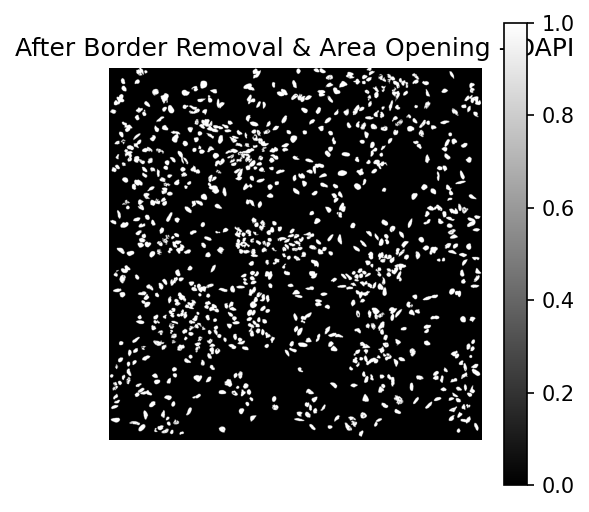

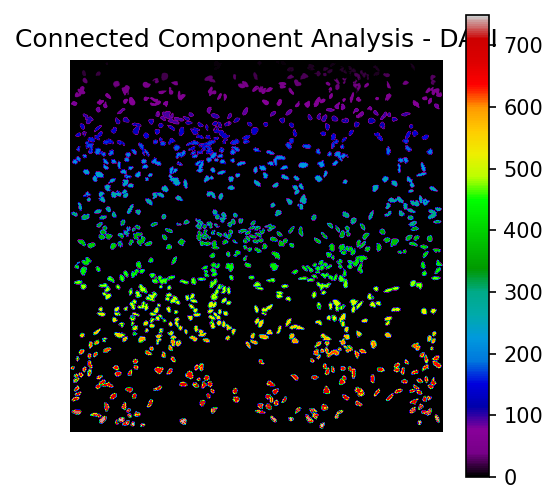

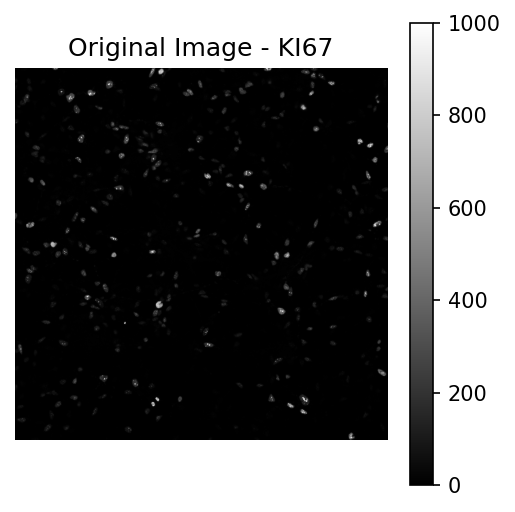

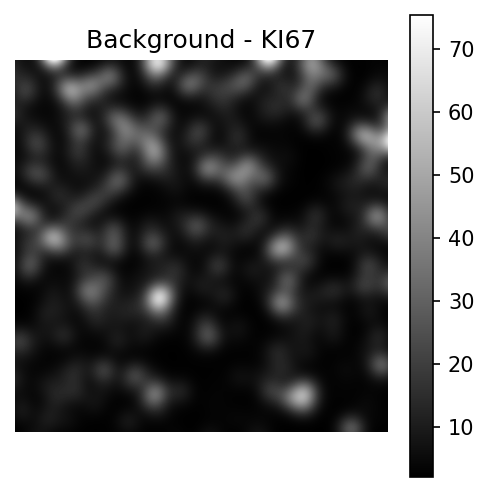

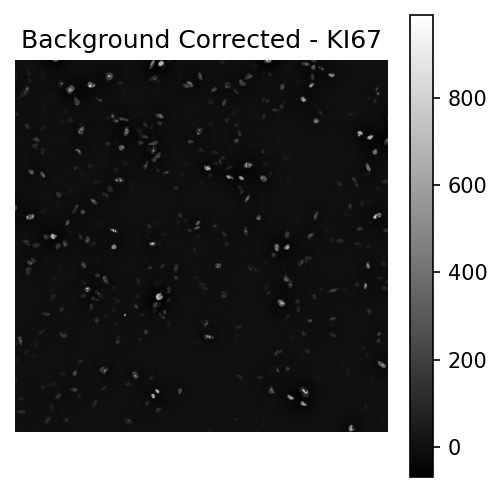

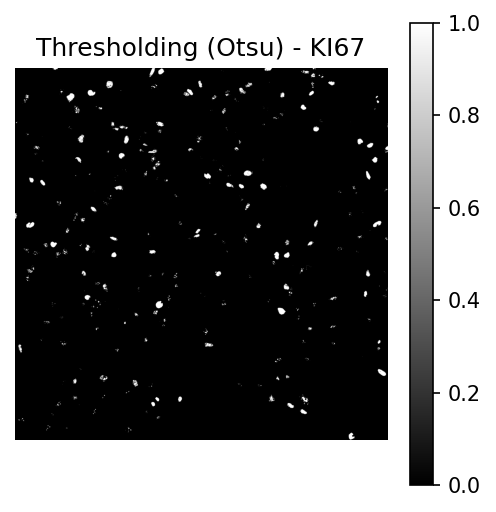

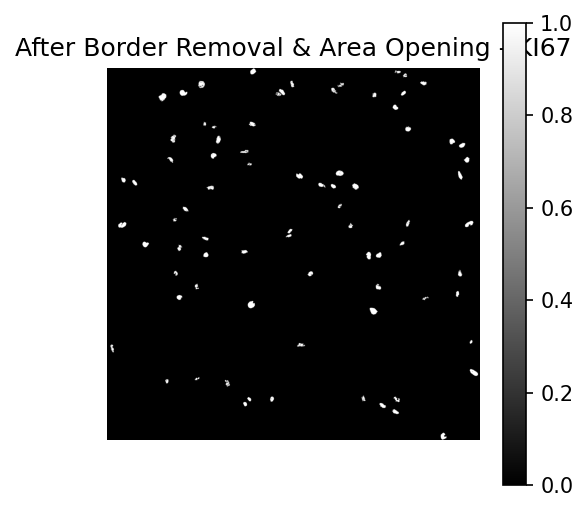

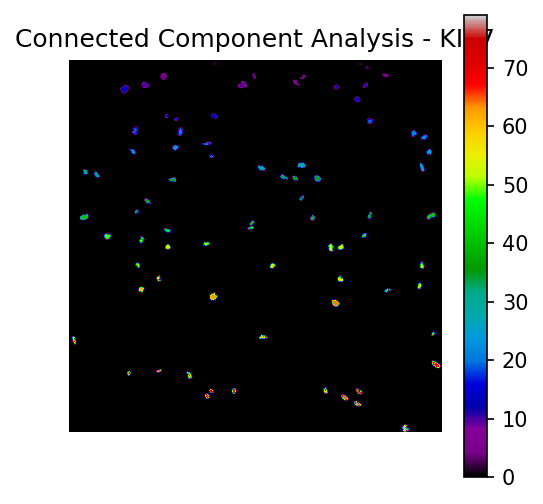

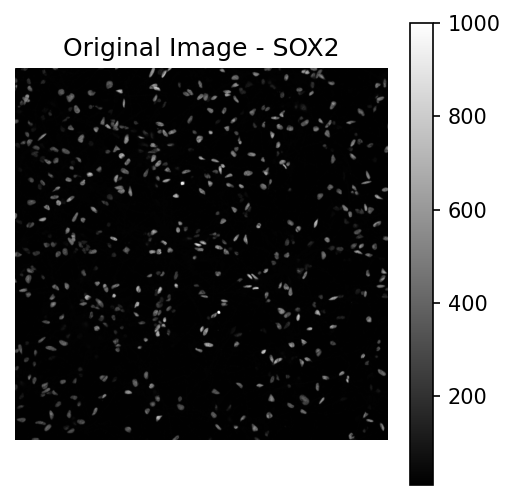

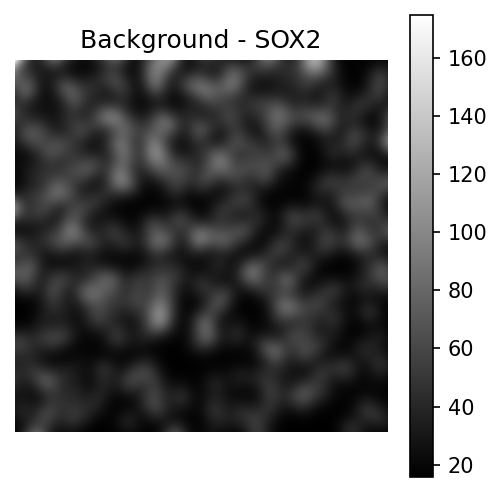

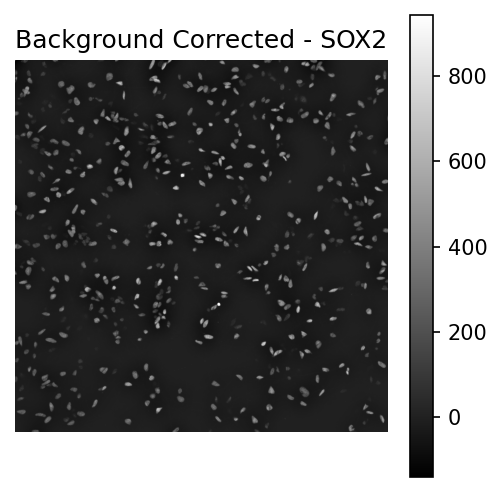

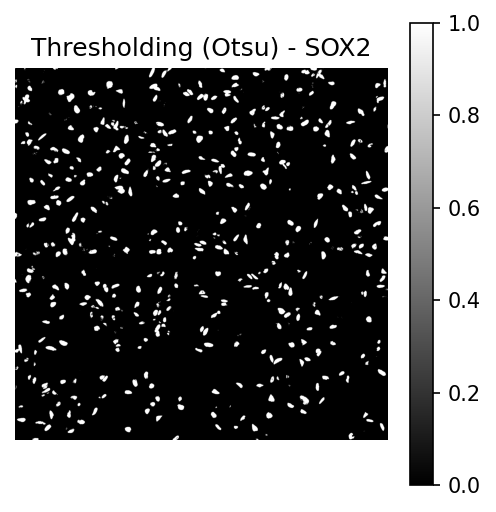

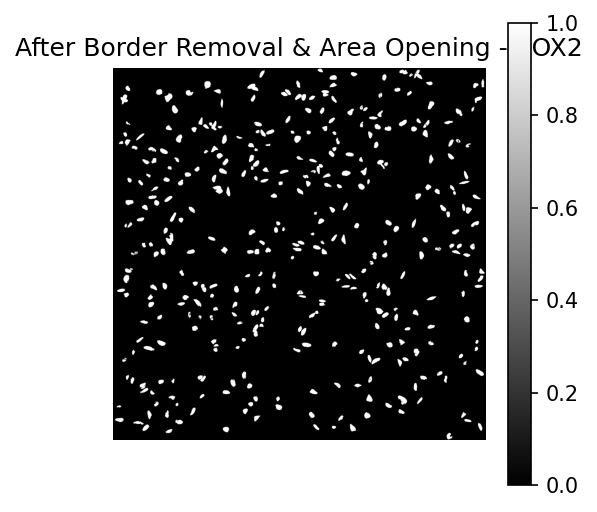

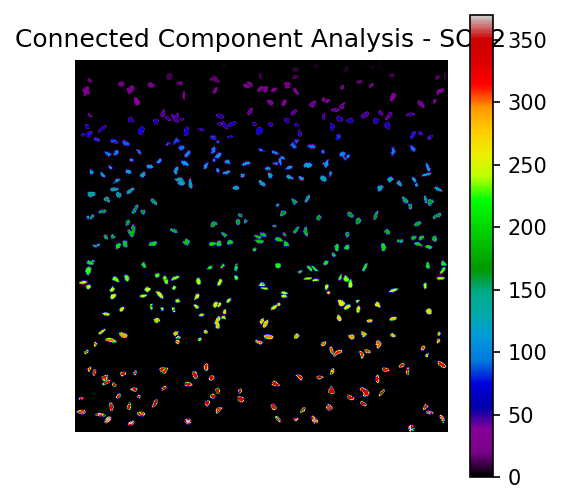

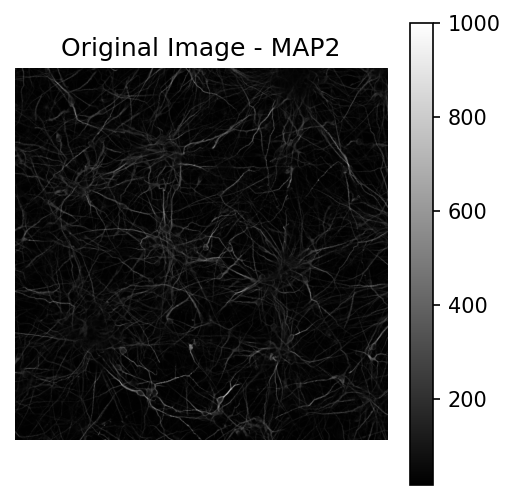

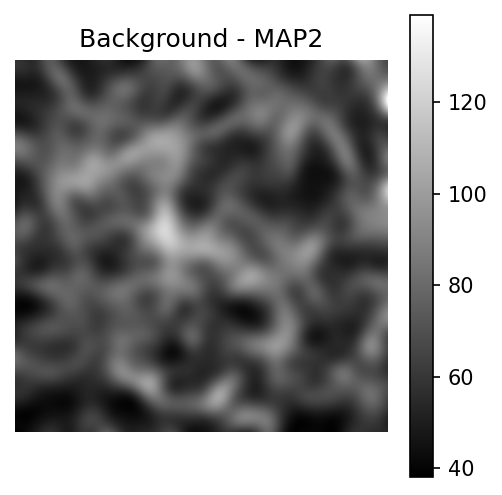

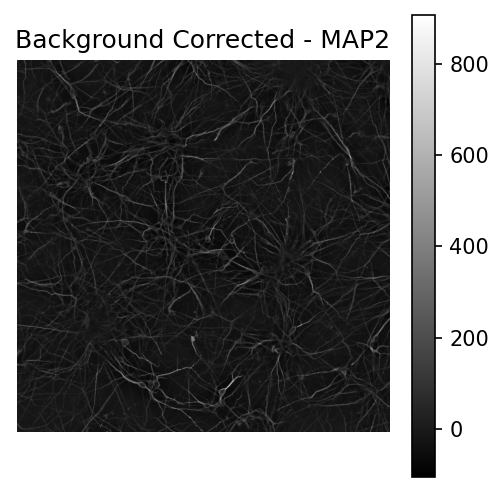

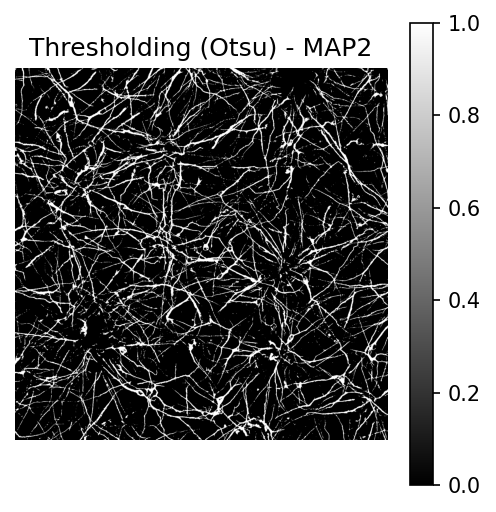

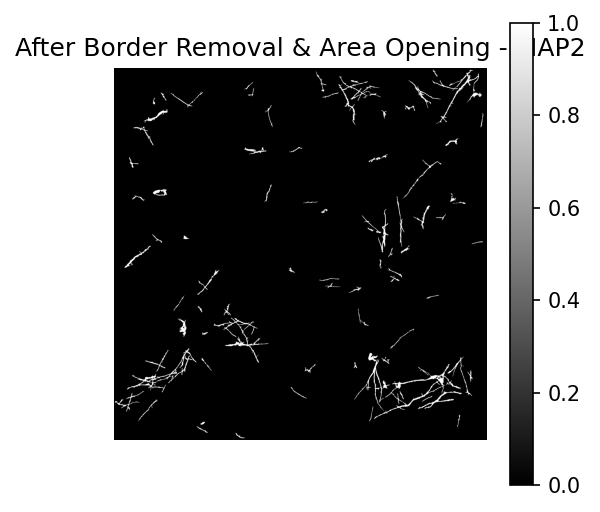

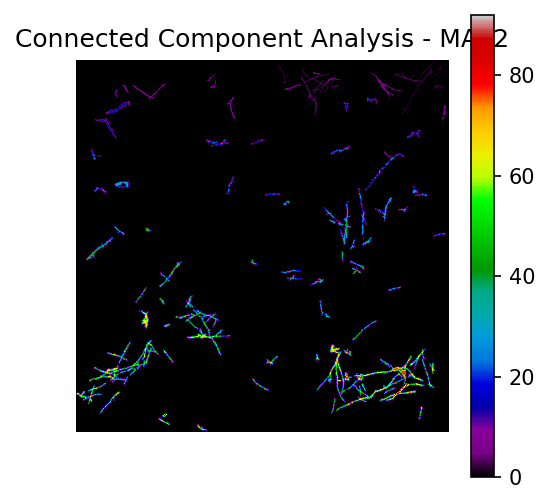

  Channel  Cell Count     Area  Normalized (by DAPI)
0    DAPI         749      NaN              1.000000
1    KI67          79      NaN              0.105474
2    SOX2         370      NaN              0.493992
3    MAP2          92  84702.0            113.086782


In [22]:
# Main function to execute the analysis
def main():
    file_path = '/Users/meliscelik/Desktop/20240605_d63_wt_ki67_488_sox2_555_map2_638_20x001-maxip_xy4 copy.nd2'
    image = load_nd2_file(file_path)

    # Access individual channels
    channels = [image[i].squeeze() for i in range(image.shape[0])]
    channel_names = ['DAPI', 'KI67', 'SOX2', 'MAP2']

    # Store results for each channel
    results = {}
    area_map2 = 0  # Variable to hold MAP2 area

    for channel, name in zip(channels, channel_names):
        normalized_channel = normalize_channel(channel)
        df, lbl = process_channel(normalized_channel, name)

        if name == 'MAP2':
            area_map2 = df['area'].sum()  # Sum area for MAP2
            results[name] = df[['label', 'area']]  # Store only label and area for MAP2
        else:
            results[name] = df[['label', 'area']]  # Store label and area for other channels

    # Create a summary table for cell counts and area
    summary_rows = []  # List to hold each summary row

    # Calculate cell counts and normalized values
    dapi_count = len(results['DAPI'])  # Get DAPI count for normalization
    for channel in channel_names:
        if channel == 'MAP2':
            cell_count = len(results[channel])
            normalized_value = area_map2 / dapi_count if dapi_count > 0 else 0  # Normalize MAP2 area by DAPI count
            summary_rows.append({'Channel': channel, 'Cell Count': cell_count, 
                                 'Area': area_map2, 'Normalized (by DAPI)': normalized_value})  # Append to list
        else:
            cell_count = len(results[channel])
            normalized_value = cell_count / dapi_count if dapi_count > 0 else 0
            summary_rows.append({'Channel': channel, 'Cell Count': cell_count, 
                                 'Area': None, 'Normalized (by DAPI)': normalized_value})  # Append to list

    # Convert summary rows list to DataFrame
    summary_df = pd.DataFrame(summary_rows)

    # Print the summary table
    print(summary_df)

# Execute the main function
if __name__ == "__main__":
    main()
